<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Flag_of_Brazil.svg/320px-Flag_of_Brazil.svg.png">
</td>


# Analyse des sources de l'édition brésilienne du *Huff Post* (2014-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre <i>notebook</i> et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 25
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les **20&nbsp;831 articles** de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Brésil"
huff = huff[huff.pays == edition]
huff.shape

(20831, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

HuffPost Brasil                     20654
BBC Brasil                          15   
O Globo                             13   
Extra Online                        8    
São Paulo                           8    
EL PAÍS                             7    
BuzzFeed                            5    
Estadão                             5    
Política                            4    
Exame                               4    
VEJA.com                            4    
Elástica                            4    
                                   ..    
CASA                                1    
Processo de Impeachment de Dilma    1    
São Carlos e Região                 1    
UOL TV e Famosos                    1    
Bem Estar                           1    
Rio Grande do Sul                   1    
catavento*                          1    
O Dia                               1    
Catraca Livre                       1    
Pop & Arte                          1    
revistacrescer.globo.com          

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

HuffPost Brasil    20654
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(20654, 13)

In [7]:
len(huff) - len(huff[metaHP])

177

Le calcul ci-haut nous indique qu'on a **177 articles** qu'on peut d'ores et déjà ranger dans la catégorie des articles qui ne sont *pas* rédigés par l'équipe du *HuffPost*.
<hr>
Examinons cependant de plus près notre sous-ensemble d'articles dont la balise `meta` prétend qu'ils sont issus du *HuffPost* en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

? HuffPost Brasil                                                                               3243
? Brasil Post                                                                                   1582
? Estadão Conteúdo                                                                              1442
Cleber Facchi Jornalista, Editor de Mídias Sociais, Music Geek e criador do blog Miojo Indie    1148
Caio Delcolli Repórter de diversão do HuffPost Brasil e usuário de All Star verde               967 
Grasielle Castro Editora de estratégias e tendências, HuffPost Brasil                           735 
Andréa Martinelli Editora no HuffPost Brasil                                                    677 
Ione Aguiar Editora de Mídias Sociais do HuffPost Brasil                                        633 
Diego Iraheta Editor Chefe, HuffPost Brasil                                                     569 
Luiza Belloni Repórter de Notícias no HuffPost Brasil                                      

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;?&nbsp;»).<br>
On va les placer dans la variable `inconnu`.<br>
Ils représentent un peu plus de **2,6%** du total des articles de cette édition du *Huffington&nbsp;Post*.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(543, 2.6066919494983436)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]|Brasil Post",na=False)
huff[metaHP][signeHP].shape

(13343, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(? HuffPost Brasil                                                                    3243
 ? Brasil Post                                                                        1582
 Caio Delcolli Repórter de diversão do HuffPost Brasil e usuário de All Star verde    967 
 Grasielle Castro Editora de estratégias e tendências, HuffPost Brasil                735 
 Andréa Martinelli Editora no HuffPost Brasil                                         677 
 Ione Aguiar Editora de Mídias Sociais do HuffPost Brasil                             633 
 Diego Iraheta Editor Chefe, HuffPost Brasil                                          569 
 Luiza Belloni Repórter de Notícias no HuffPost Brasil                                548 
 Rafael Nardini Editor-assistente de notícias no HuffPost Brasil                      526 
 ? Do Brasil Post                                                                     378 
 Ana Beatriz Rosa Repórter de Vozes, Mulheres e Notícias, HuffPost Brasil             349 

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **13&nbsp;343 articles** signés par **354 signataires différents**.<br>
Cela représente près des deux-tiers de l'ensemble des articles publiés par l'édition brésilienne du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(13343, 64.053574000288023)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer une nouvelle variable qu'on va appeler `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]|Brasil Post",na=False)
huff[metaHP][NONsigneHP].shape

(7311, 13)

Qui sont ces auteurs qui ne font pas partie de l'équipe du *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count()

(? Estadão Conteúdo                                                                              1442
 Cleber Facchi Jornalista, Editor de Mídias Sociais, Music Geek e criador do blog Miojo Indie    1148
 ? ?                                                                                             543 
 ? Agência Brasil                                                                                467 
 ? Veja.com                                                                                      409 
 ? Superinteressante                                                                             248 
 Larissa Baltazar                                                                                246 
 Daniela Carasco                                                                                 230 
 Elizabeth Costa Jornalista                                                                      180 
 ? MdeMulher                                                                      

Des quelque 300 signataires ci-dessus, par contre, on trouve quelques «&nbsp;employés fantôme&nbsp;».

C'est le cas de *«&nbsp;Cleber Facchi Jornalista, Editor de Mídias Sociais, Music Geek e criador do blog Miojo Indie&nbsp;»*, qui compte **1&nbsp;148 articles**. Selon [sa page d'auteur](http://www.huffpostbrasil.com/author/cleber-facchi/), c'est bel et bien un employé du *Brasil Post*.

C'est également le cas de *«&nbsp;Bill Bradley Entertainment Editor&nbsp;»*, qui compte **18 articles**. Selon [sa page d'auteur](http://www.huffingtonpost.com/author/bill-bradley), c'est un employé de l'édition américaine du *Huffington Post*.

Mais tous les autres auteurs vérifiés ne semblent pas être des employés du *HP*. Par exemple, sur [la page d'auteure de Larissa Baltazar](http://www.huffpostbrasil.com/author/larissa-baltazar/), qui signe **246 articles**, on ne trouve aucune mention qu'elle est une employée du *Brasil Post*, pas plus que sur [son compte Twitter](https://twitter.com/larissabaltazar). Même chose avec Pedro Sibahi, qui signe **107 articles**. Ni sa [page d'auteur](http://www.huffpostbrasil.com/author/pedro-sibahi/) ni [son profi Twitter](https://twitter.com/psibahi) n'indiquent qu'il est employé de l'édition brésilienne du *Post*.

On ne va donc considérer que les signataires qui comprennent le mot *«&nbsp;Editor&nbsp;»* comme faisant partie de l'équipe du *HuffPost Brasil*.

In [15]:
fantomes = huff[metaHP][NONsigneHP].byline.str.contains("Editor")
huff[metaHP][NONsigneHP][fantomes].byline.value_counts(), huff[metaHP][NONsigneHP][fantomes].byline.value_counts().sum()

(Cleber Facchi Jornalista, Editor de Mídias Sociais, Music Geek e criador do blog Miojo Indie    1148
 Sarah Klein Senior Editor, Health & Fitness; Certified Personal Trainer                         15  
 Bill Bradley Entertainment Editor                                                               8   
 Amanda L. Chan Managing Editor, Healthy Living                                                  8   
 Ed Mazza Overnight Editor                                                                       6   
 Anna Almendrala Healthy Living Editor                                                           6   
 Erin Whitney Associate Entertainment Editor                                                     3   
 Emily Peck Executive Editor, Business and Technology                                            3   
 Roque Planas Editor, Latino Voices                                                              3   
 Arti Patel Editor, Lifestyle                                                     

Il y en a 1&nbsp;223, auxquels il faut cependant retrancher quelques intrus, comme *«&nbsp;Sarah Klein Senior Editor, Health & Fitness; Certified Personal Trainer&nbsp;»* ou *«&nbsp;Laura Schocker Executive Editor, Realsimple.com&nbsp;»*, par exemples.

Il y a 23 de ces intrus. On se retrouve donc avec 1&nbsp;200 auteurs fantôme du *HP*, qu'il faut ajouter à notre variable `HP_oui`. Cela donne près de **70%** d'articles signés par des employés de la maison.

In [16]:
HP_oui = huff[metaHP][signeHP].pays.count() + 1200
HP_oui, (HP_oui/len(huff))*100

(14543, 69.814219192549558)

Il nous reste donc à calculer le pourcentage des articles signés par des auteurs externes.

Il faut ici soustraire de notre variable `NONsignéHP` les articles contenus dans les deux variables `inconnu1` et `inconnu2`, additionner les articles qu'on a identifiés au début dont la balise `meta` ne pouvait pas être associée au *HuffPost* et retrancher les auteurs fantômes qu'on a identifiés ci-dessus.

In [17]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 1200
HP_non, (HP_non/len(huff))*100

(5745, 27.57908885795209)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

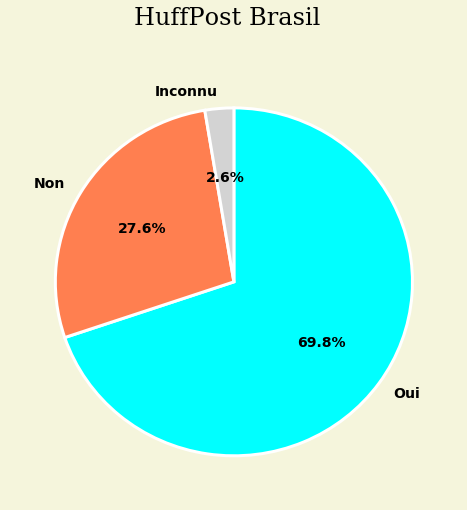

In [18]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Brasil", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Dernier exercice&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par l'édition brésilienne.

In [19]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

País                          5048
diversão                      3408
mulheres                      2494
entretenimento                2491
brasil mundo                  2476
comportamento                 2458
brasil                        2223
viral                         2199
brasil país                   2012
notícias                      1606
mulher                        1322
dilma rousseff                1285
                              ... 
financial times dilma         1   
reforma-do-ensino-medio       1   
desrespeito à Constituição    1   
viola minha viola             1   
mell brites                   1   
david schwimmer               1   
pior nevasca japão            1   
carnaval em recife            1   
trabalho no exterior          1   
um terço dos brasileiros      1   
famosas no tapete vermelho    1   
                              1   
Length: 61738, dtype: int64